# Importing tools

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
pip install prophet

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from numpy.random import normal, seed
import math
from sklearn.metrics import mean_squared_error

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import norm
import scipy.stats as scs

from prophet import Prophet

Dataset: This includes the stock data of Nifty-50 index from NSE (National Stock Exchange) India over the last 20 years (2000 - 2019). I am going to explore the stock market data of ICICI bank.

In [ ]:
df = pd.read_csv("/content/ICICIBANK.csv", parse_dates=["Date"],index_col="Date")
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,ICICIBANK,EQ,69.20,74.35,74.75,71.40,74.75,74.75,73.20,286260,2.095439e+12,NaN,NaN,NaN
2000-01-04,ICICIBANK,EQ,74.75,73.05,78.50,71.00,73.25,73.05,73.38,296264,2.173893e+12,NaN,NaN,NaN
2000-01-05,ICICIBANK,EQ,73.05,70.00,73.50,67.50,70.00,69.50,70.85,227624,1.612794e+12,NaN,NaN,NaN
2000-01-06,ICICIBANK,EQ,69.50,71.00,74.00,69.55,69.75,70.05,72.04,275149,1.982121e+12,NaN,NaN,NaN
2000-01-07,ICICIBANK,EQ,70.05,69.00,72.50,66.00,67.00,67.40,68.72,138809,9.538882e+11,NaN,NaN,NaN


In [ ]:
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2021-04-26,ICICIBANK,EQ,569.95,602.00,605.50,588.0,588.7,591.10,596.22,62584522,3.731429e+15,546696.0,16913351.0,0.2702
2021-04-27,ICICIBANK,EQ,591.10,593.25,601.95,591.1,599.0,598.75,597.63,24239685,1.448630e+15,233412.0,9056247.0,0.3736
2021-04-28,ICICIBANK,EQ,598.75,598.00,622.80,598.0,619.7,621.35,612.57,33292864,2.039422e+15,295406.0,14011476.0,0.4209
2021-04-29,ICICIBANK,EQ,621.35,622.55,628.45,609.0,621.0,621.45,619.55,34537860,2.139792e+15,304029.0,10324897.0,0.2989
2021-04-30,ICICIBANK,EQ,621.45,610.10,616.35,598.1,599.7,600.50,607.02,23653258,1.435801e+15,247055.0,7292392.0,0.3083


# Features:
1. Series: Here EQ stands for equity series of stock market.
2. Prev Close: The closing price of the stock for the day before.
3. Open,High, Low, Last, Close: The opening price, highest price, lowest price, last price and closing price of ICICI shares on the current day.
4. **VWAP**: Volume Weighted Average Price,the **target variable** to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.
5. Volume: Volume of shares traded on the current day.
6. Turnover: It is a measure of stock liquidity calculated by dividing the total number of shares traded over a period by the average number of shares outstanding for the period.
7. Trades: total number of trades on the current day.
8. Deliverable Volume:  is the quantity of shares which actually move from one set of people to another set of people.
9. Deliverable(%): Deliverable volume in percentage.

# Exploring the data
Let's explore the missing values, trend, seasonality, correlation and noise in the data.

In [ ]:
df.shape

(5306, 14)

In [ ]:
# for feature in df.columns:
#     print("{} : {}".format(feature,df[feature].isna().sum()))
df.isna().sum()

,0
Symbol,0
Series,0
Prev Close,0
Open,0
High,0
Low,0
Last,0
Close,0
VWAP,0
Volume,0


Trades, Deliverable volume and %Deliverable are the columns with missing values.

In [ ]:
print("Percentage of missing trade values = {:.2f}".format(100*(df['Trades'].isna().sum())/df.shape[0]))
print("Percentage of missing Deliverable Volume values = {:.2f}".format(100*(df['Deliverable Volume'].isna().sum())/df.shape[0]))
print("Percentage of missing %Deliverble values = {:.2f}".format(100*(df['%Deliverble'].isna().sum())/df.shape[0]))

Percentage of missing trade values = 53.71
Percentage of missing Deliverable Volume values = 9.74
Percentage of missing %Deliverble values = 9.74


So more than 50% trade data is missing, while only 10% each of deliverable volume and deliverable% is missing. We can drop the rows where deliverable volume is missing. For trade data, we will visualize it to understand the best statistic for imputation.

In [ ]:
df = df[df['Deliverable Volume'] >0]

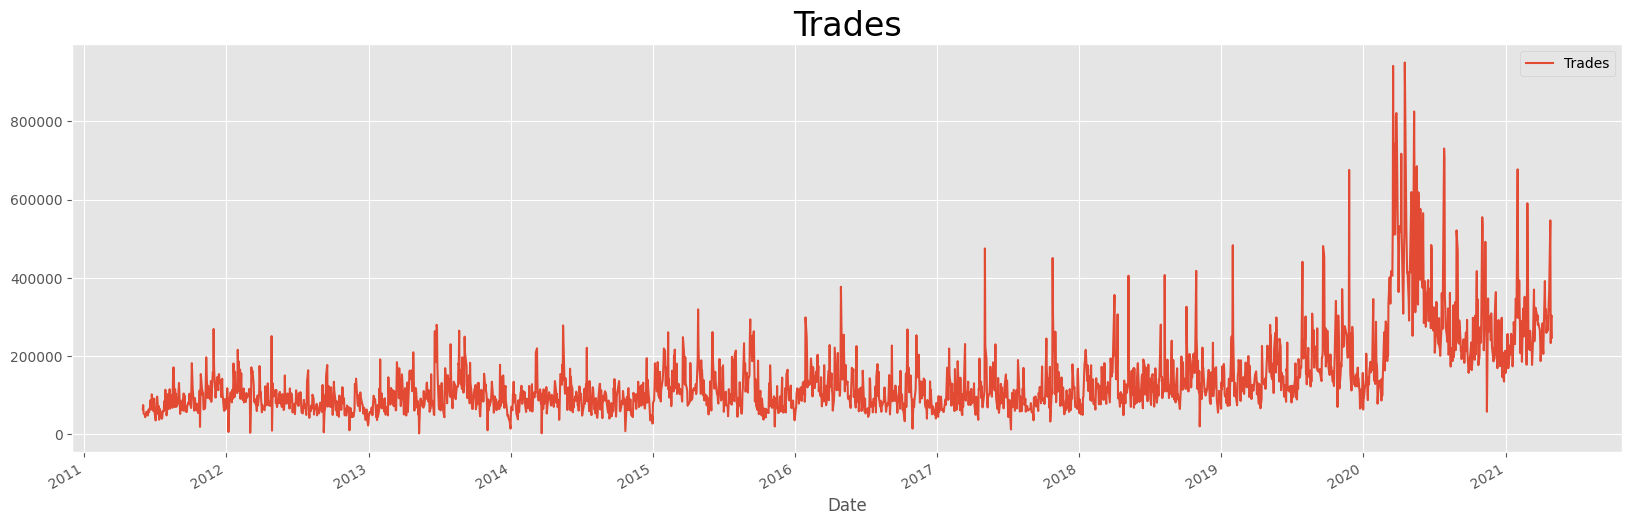

In [ ]:
ax = df[['Trades']].plot(figsize=(20, 6))
ax.set_title('Trades', fontsize=24);

We can see that trade values show a pulse in growth from the period of 2020 - 2021. To fill the NaN values, perhaps the safest option is to forward fill. But since many consecutive rows have missing values, we can fill with mean value.

In [ ]:
df['Trades'].ffill(axis = 0)
trade_data = df.loc[df.index<='2019']
mean = round(trade_data['Trades'].mean(),1)
df["Trades"].fillna(value = mean,inplace = True)

/tmp/ipython-input-11-3066436986.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# Visualizing trends in stock prices

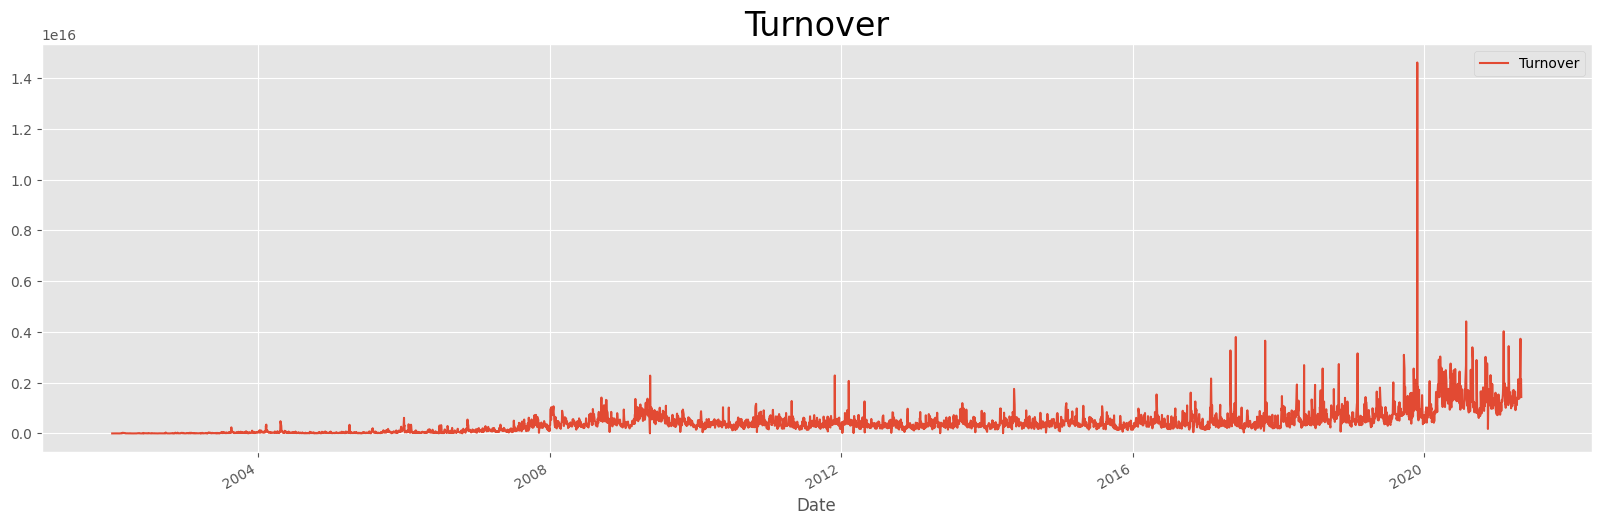

In [ ]:
ax = df[['Turnover']].plot(figsize=(20, 6))
ax.set_title('Turnover', fontsize=24);

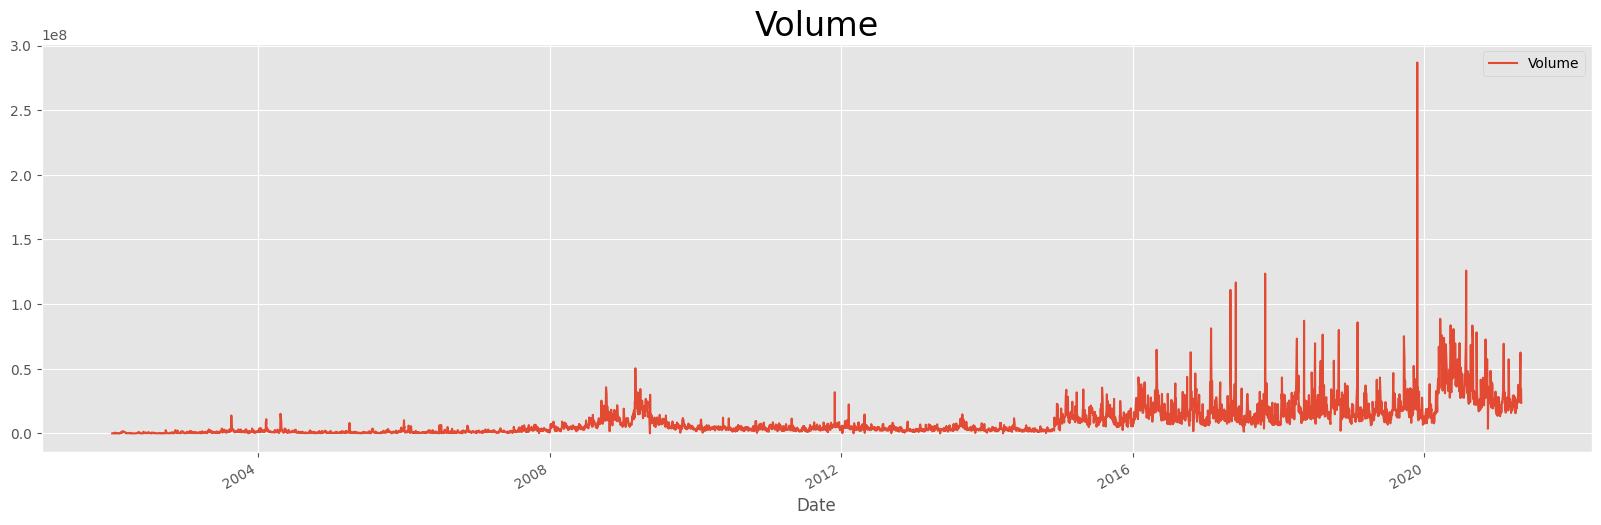

In [ ]:
ax = df[['Volume']].plot(figsize=(20, 6))
ax.set_title('Volume', fontsize=24);

The volume of shares traded showed a sharp growth during the period of 20-21.

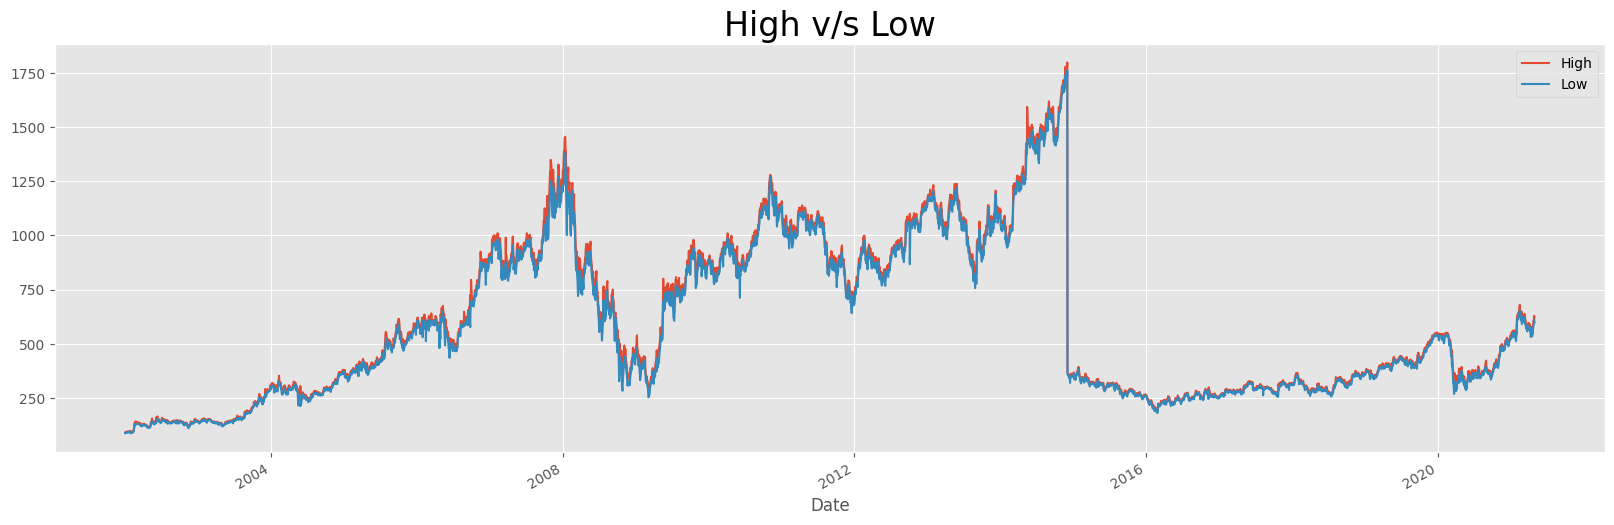

In [ ]:
ax = df[['High', 'Low']].plot(figsize=(20, 6))
ax.set_title('High v/s Low', fontsize=24);

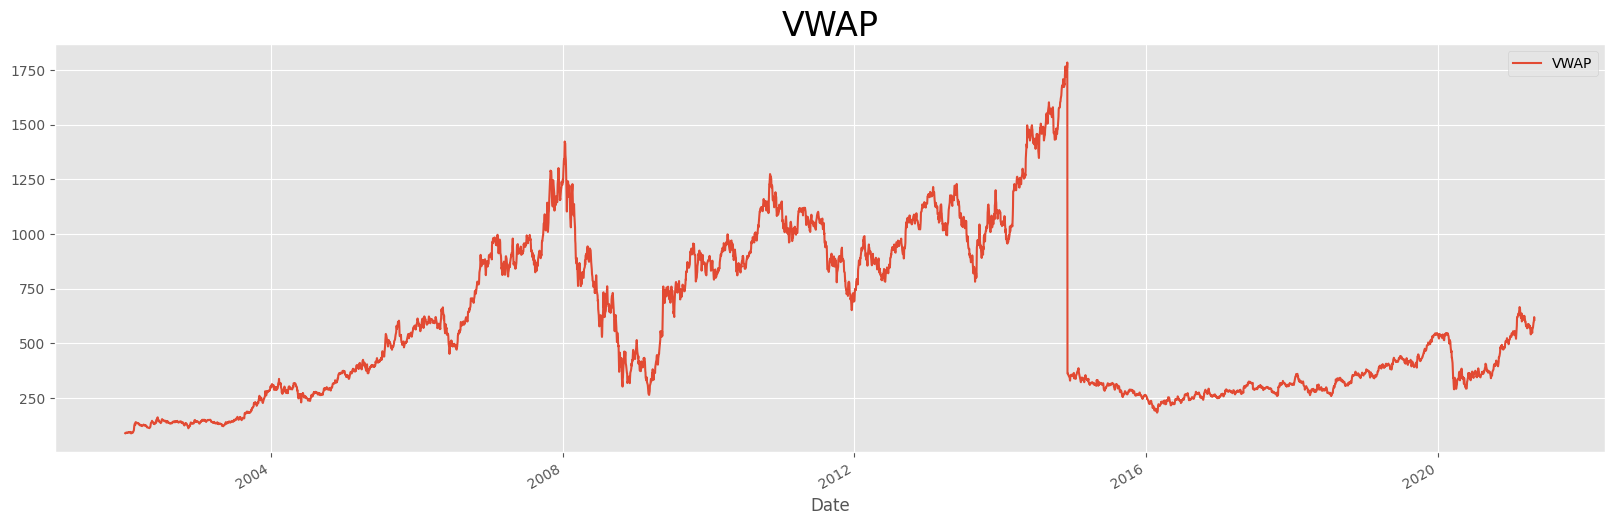

In [ ]:
ax = df[['VWAP']].plot(figsize=(20, 6))
ax.set_title('VWAP', fontsize=24);

Even though turnover and volume increased during the year 20-21, the prices dropped significantly. This explains the fact that, due to the pandemic
Covid-19, many investors took the advantage of dropping prices to buy stocks in bulk, perhaps looking forward to sell when industries regain momentum.

Text(0.5, 1.0, 'End of year VWAP for ICICI bank')

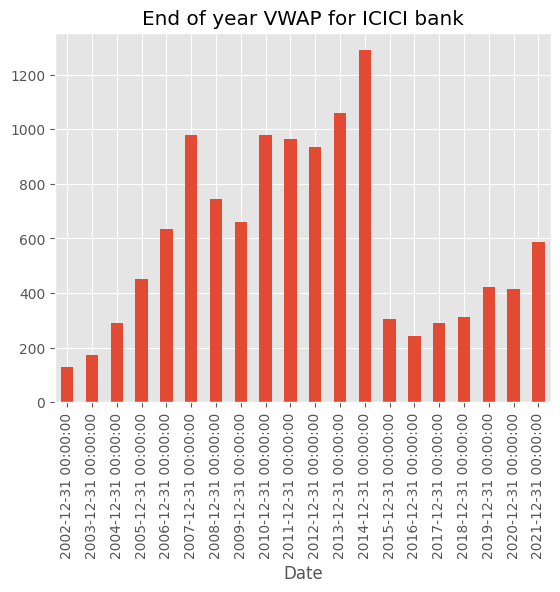

In [ ]:
df['VWAP'].resample('YE').mean().plot(kind='bar')
plt.title('End of year VWAP for ICICI bank')

Text(0.5, 1.0, 'Yearly Mean VWAP for ICICI bank')

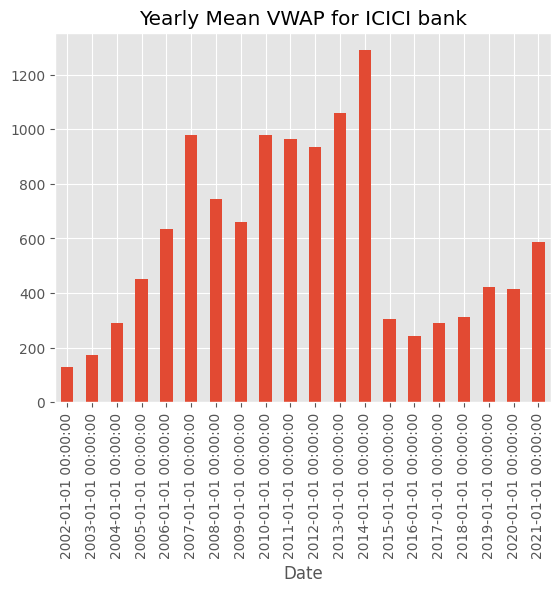

In [ ]:
df['VWAP'].resample('YS').mean().plot(kind='bar')
plt.title('Yearly Mean VWAP for ICICI bank')

Text(0.5, 1.0, 'Monthly Mean 2010 VWAP for ICICI bank')

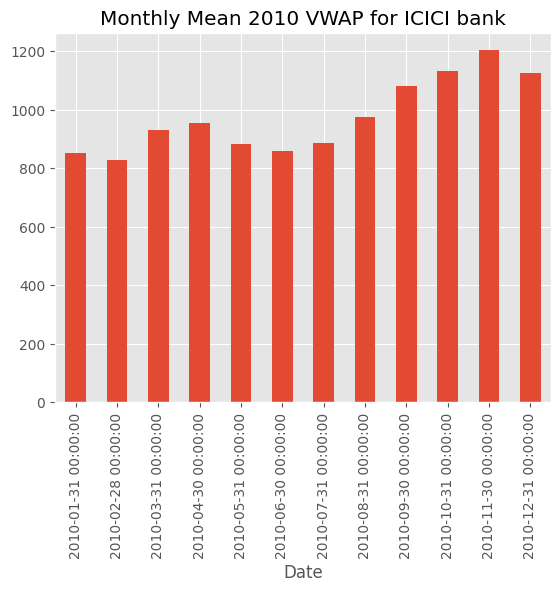

In [ ]:
df['VWAP']['2010'].resample('ME').mean().plot(kind='bar')
plt.title('Monthly Mean 2010 VWAP for ICICI bank')

Text(0.5, 1.0, 'Monthly Mean 2015 VWAP for ICICI bank')

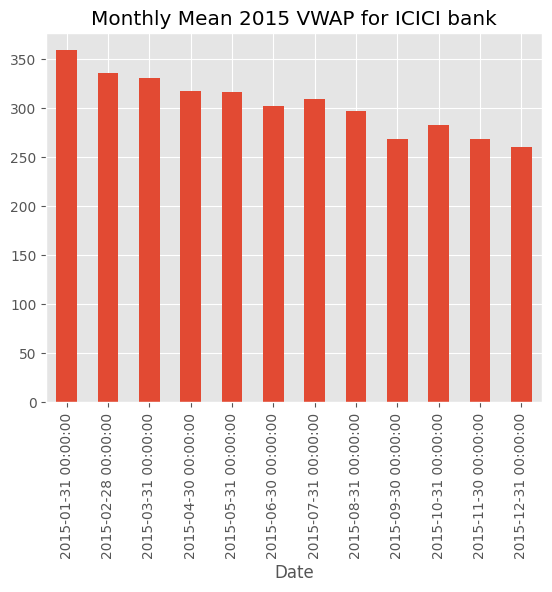

In [ ]:
df['VWAP']['2015'].resample('ME').mean().plot(kind='bar')
plt.title('Monthly Mean 2015 VWAP for ICICI bank')

Text(0.5, 1.0, 'Monthly Mean 2020 VWAP for ICICI bank')

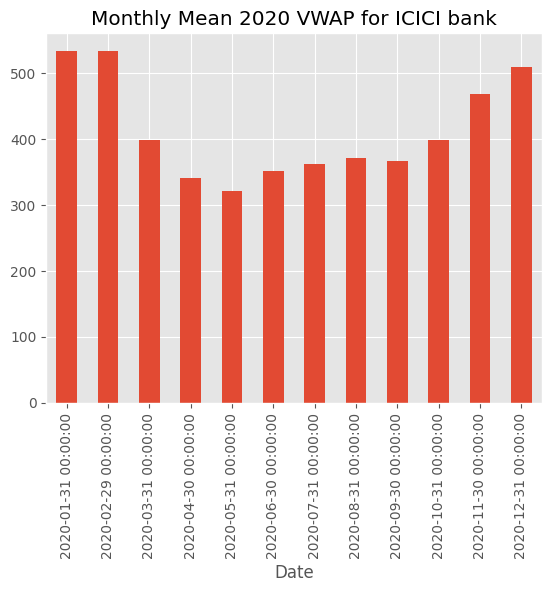

In [ ]:
df['VWAP']['2020'].resample('ME').mean().plot(kind='bar')
plt.title('Monthly Mean 2020 VWAP for ICICI bank')

VWAP has decreased on average in a decade(2010-2020).

Box-Cox Transformation - to generate a uniform distribution.

Lambda: 0.179596


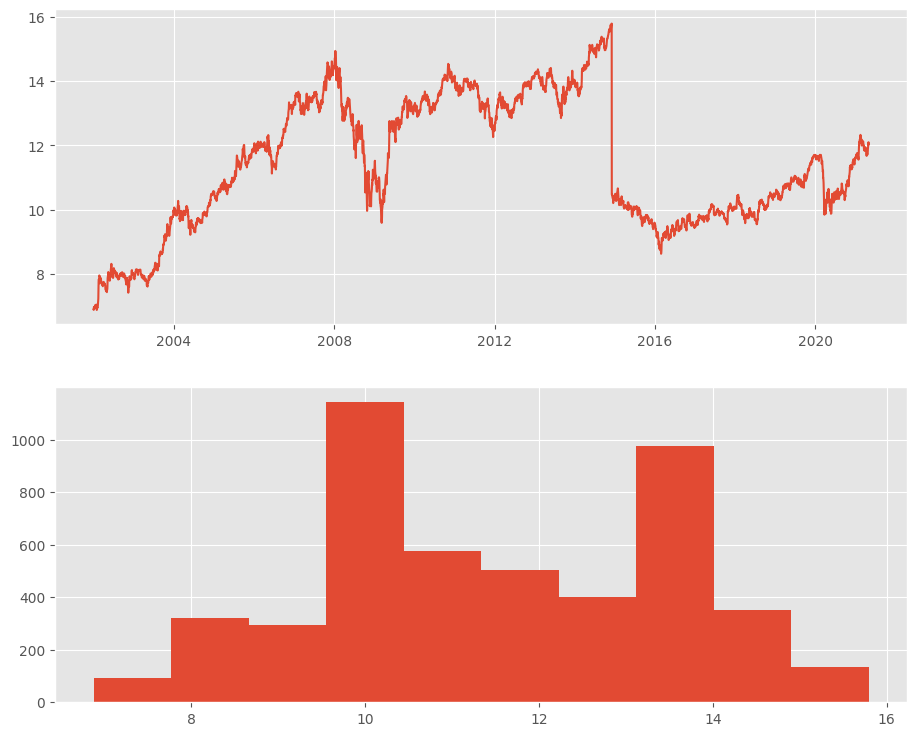

In [ ]:
from scipy.stats import boxcox
df['vwap_boxcox'],lam = boxcox(df['VWAP'])
print('Lambda: %f' % lam)
rcParams['figure.figsize'] = 11, 9
pyplot.figure(1)
# line plot
pyplot.subplot(211)
pyplot.plot(df['vwap_boxcox'])
# histogram
pyplot.subplot(212)
pyplot.hist(df['vwap_boxcox'])
pyplot.show()

# Moving average smoothing
Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

By plotting rolling

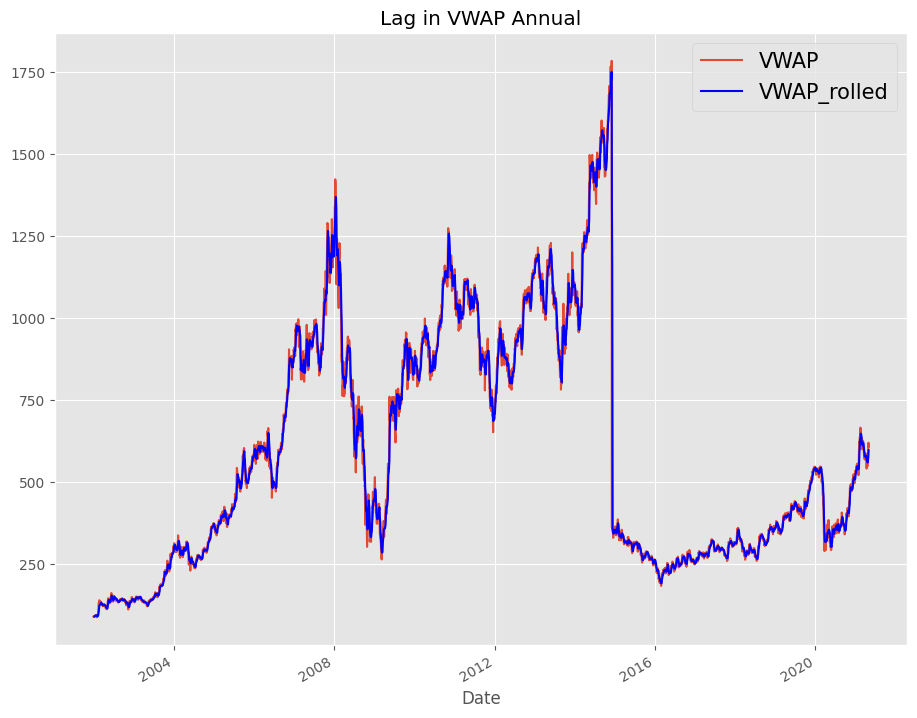

In [ ]:
rolling_vwap = df['VWAP'].rolling(window=7)
df['VWAP_rolled'] = rolling_vwap.mean()
df['VWAP'].plot()
df['VWAP_rolled'].plot(color='blue')
plt.title('Lag in VWAP Annual')
plt.legend(fontsize=15)
pyplot.show()

# Autocorrelation plot

Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
 "Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot..." - *Introduction to Time Series Forecasting With Python*, Jason Brownlee.

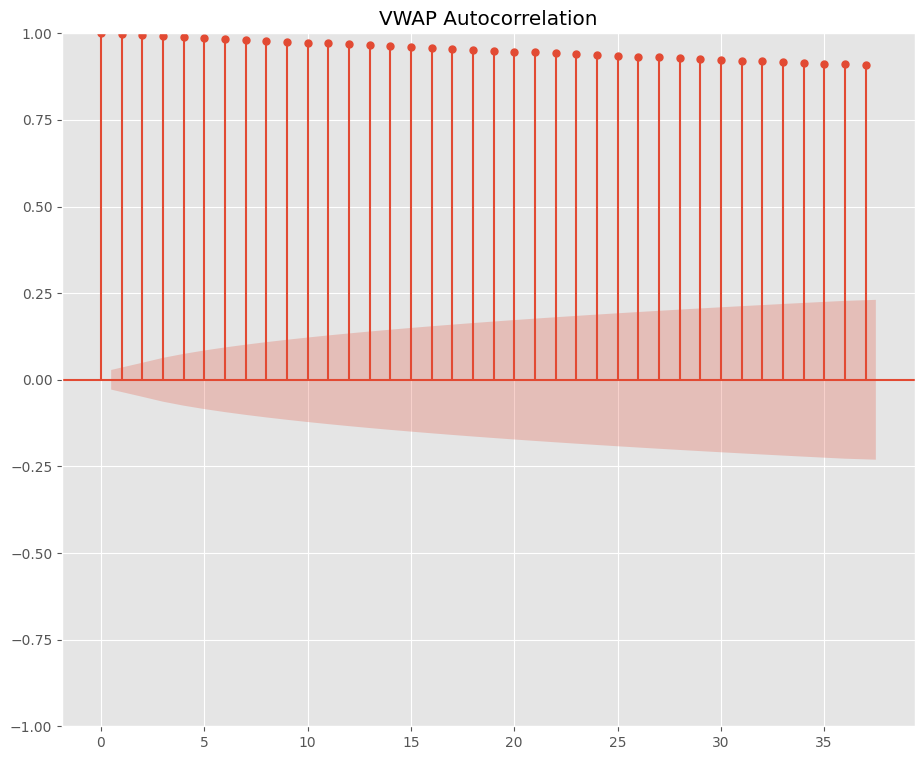

In [ ]:
plot_acf(df['VWAP'],title="VWAP Autocorrelation")
plt.show()

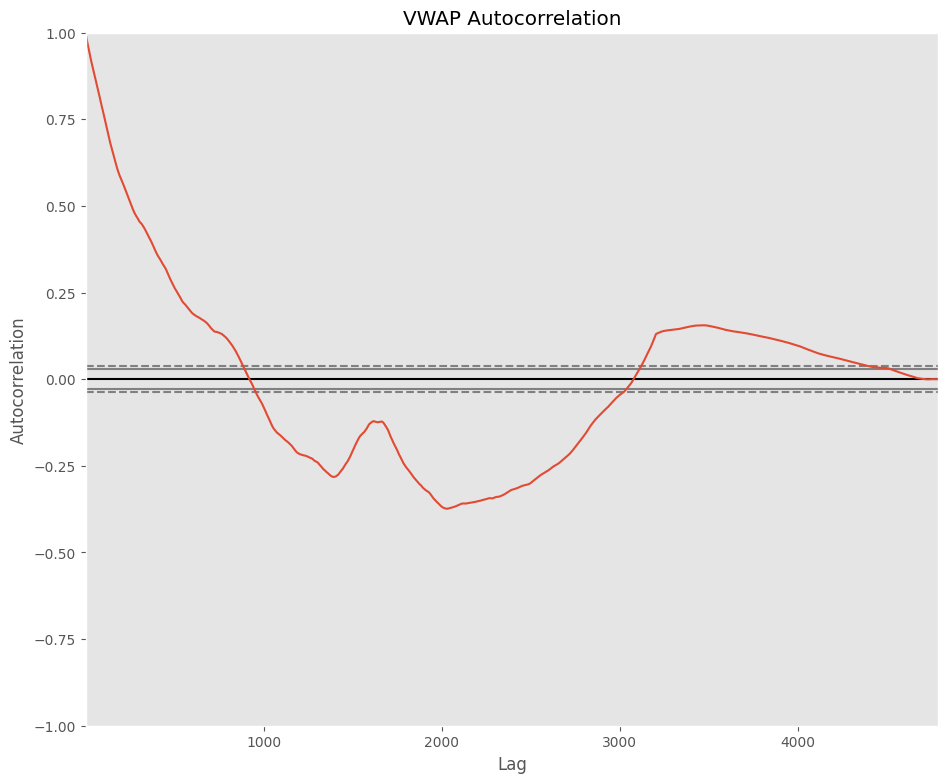

In [ ]:
autocorrelation_plot(df['VWAP'])
plt.title('VWAP Autocorrelation')
pyplot.show()

Partial Autocorrelation

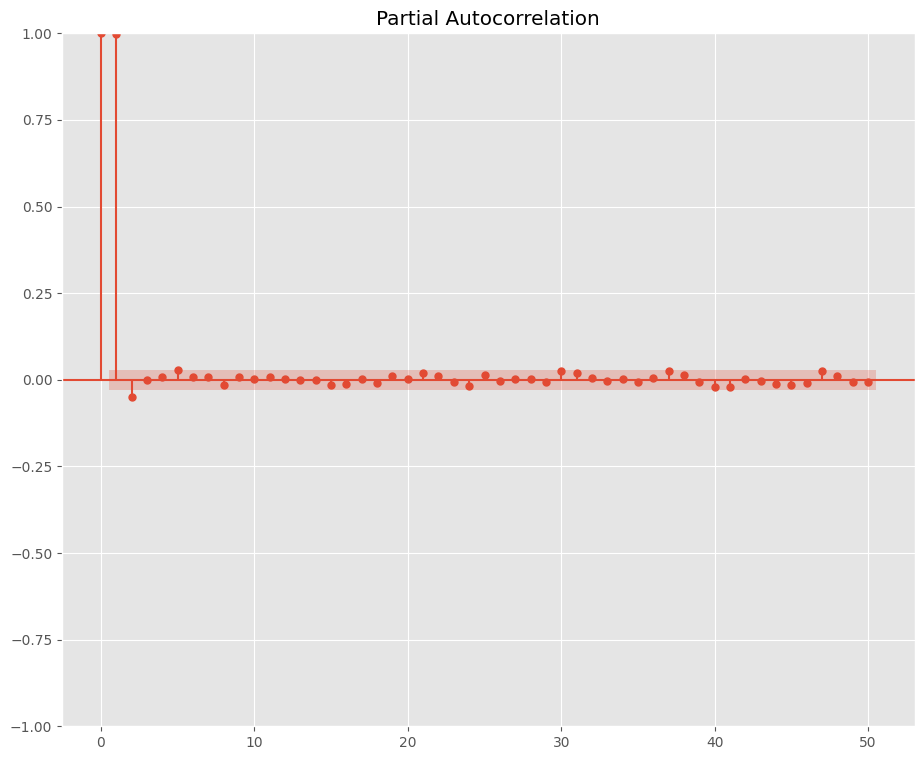

In [ ]:
plot_pacf(df['VWAP'],lags=50)
plt.show()

# Stationarity-
We'll check with the Augmented Dickey-Fuller test for stationarity in the dataset. A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

In [ ]:
result = adfuller(df['VWAP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.740467
p-value: 0.067294
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Running the example prints the test statistic value of -2.69. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). Hence the values are relatively not random, but depend on the prior recorded values.



# Decompose Time Series Data
> "Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting."- *Introduction to Time Series Forecasting With Python*, Jason Brownlee.




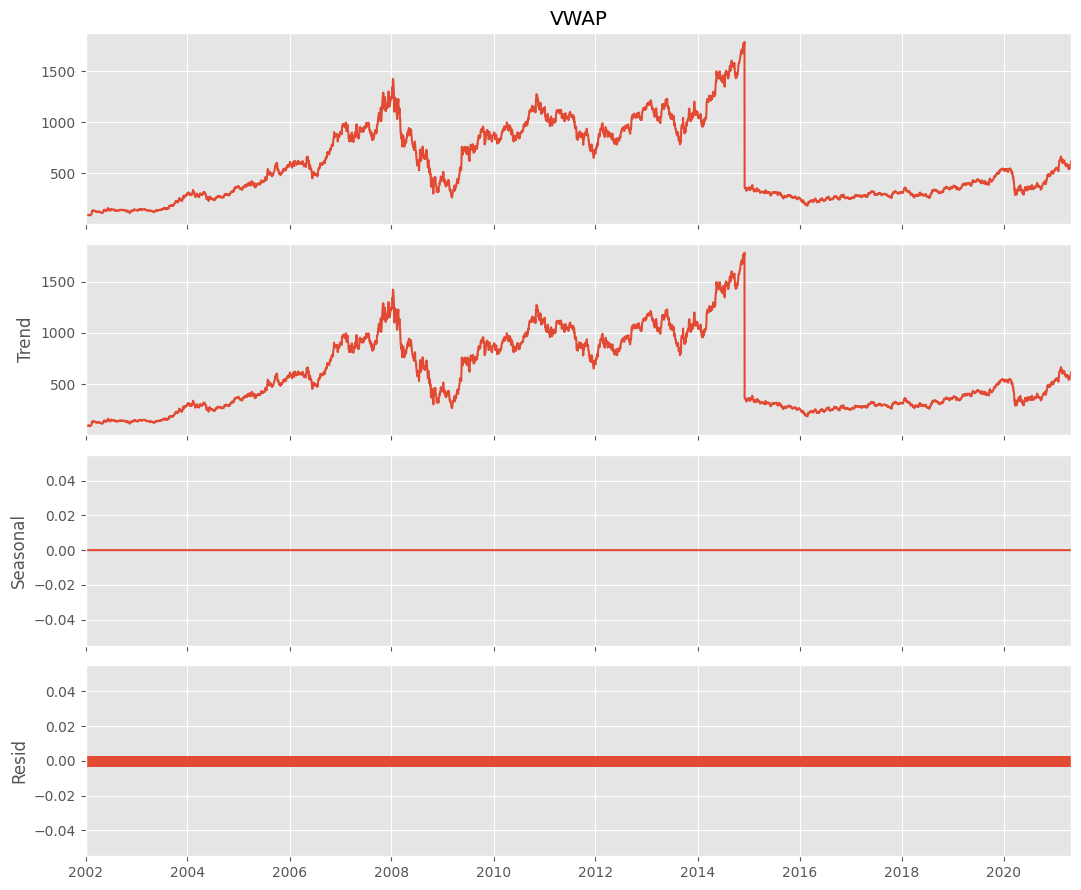

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = df['VWAP']
result = seasonal_decompose(series, model='additive', period=1)
rcParams['figure.figsize'] = 11, 9
result.plot()
pyplot.show()

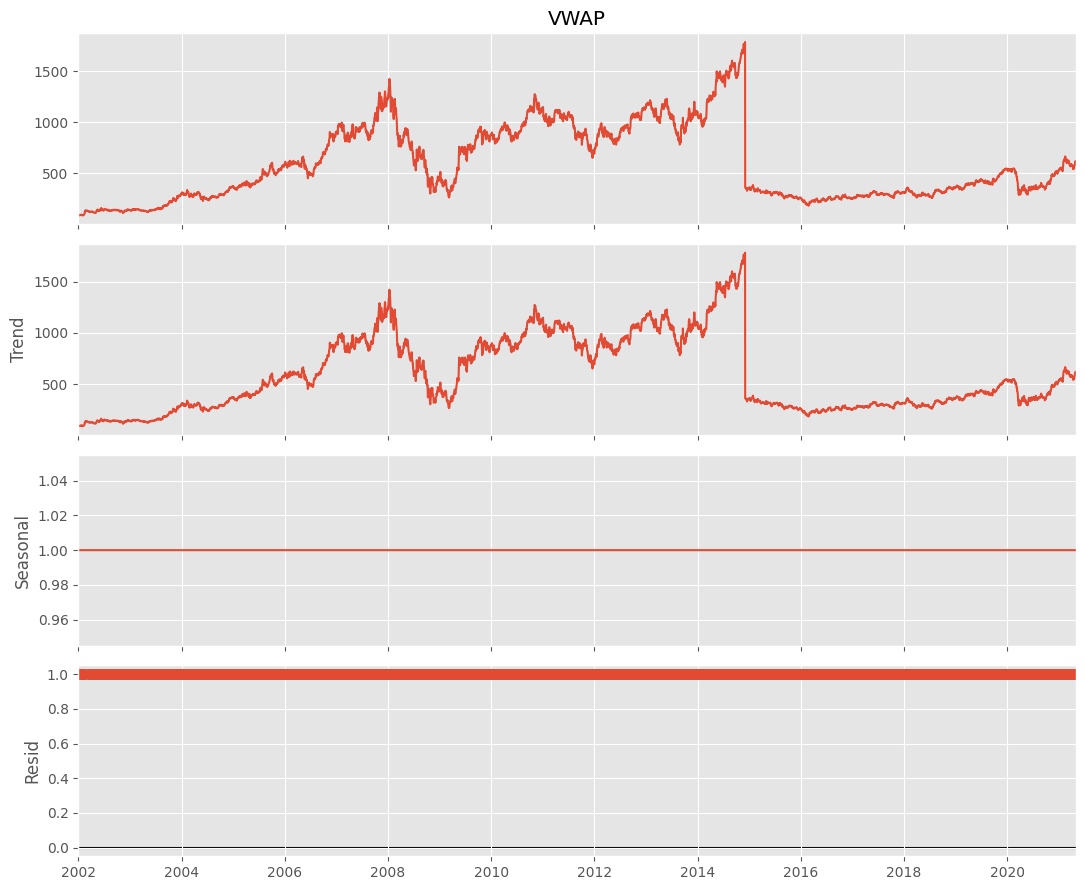

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = df['VWAP']
result = seasonal_decompose(series, model='multiplicative', period=1)
rcParams['figure.figsize'] = 11, 9
result.plot()
pyplot.show()

In [ ]:
df2 = df.copy()
df2.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,vwap_boxcox,VWAP_rolled
Date,,,,,,,,,,,,,,,,
2002-01-01,ICICIBANK,EQ,88.7,89.95,89.95,87.30,88.05,88.50,88.53,47087,4.168734e+11,105660.5,35559.0,0.7552,6.888368,NaN
2002-01-02,ICICIBANK,EQ,88.5,88.00,89.00,87.50,87.60,88.40,88.05,70982,6.249913e+11,105660.5,64128.0,0.9034,6.876212,NaN
2002-01-03,ICICIBANK,EQ,88.4,86.60,92.95,86.60,92.05,92.00,90.40,143055,1.293277e+12,105660.5,114325.0,0.7992,6.935218,NaN
2002-01-04,ICICIBANK,EQ,92.0,92.50,93.20,90.00,91.90,91.10,91.43,89792,8.209558e+11,105660.5,73659.0,0.8203,6.960685,NaN
2002-01-07,ICICIBANK,EQ,91.1,91.00,92.50,89.25,91.05,90.15,90.58,151344,1.370891e+12,105660.5,123531.0,0.8162,6.939686,NaN


# Feature Engineering:
Appling sliding window statistic on columns to obtain lag values, to be used in modelling the dataset. The mean and standard lag values of the features will be useful to forcast out of sample or test sample of VWAP.

In [ ]:
df2.reset_index(drop=False,inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df2[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df2[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df2[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df2[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df2[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df2[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    df2[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df2[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df2[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df2.fillna(df2.mean(numeric_only=True), inplace=True)

df2.set_index("Date", drop=False, inplace=True)
df2.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,2002-01-01,ICICIBANK,EQ,88.7,89.95,89.95,87.30,88.05,88.50,88.53,...,4.107885e+14,1.263222e+14,1.552462e+14,1.971207e+14,122367.226562,122267.039062,121813.546875,18041.275391,21607.65625,26340.019531
2002-01-02,2002-01-02,ICICIBANK,EQ,88.5,88.00,89.00,87.50,87.60,88.40,88.05,...,4.168734e+11,1.263222e+14,1.552462e+14,1.971207e+14,105660.500000,105660.500000,105660.500000,18041.275391,21607.65625,26340.019531
2002-01-03,2002-01-03,ICICIBANK,EQ,88.4,86.60,92.95,86.60,92.05,92.00,90.40,...,5.209324e+11,1.471616e+11,1.471616e+11,1.471616e+11,105660.500000,105660.500000,105660.500000,0.000000,0.00000,0.000000
2002-01-04,2002-01-04,ICICIBANK,EQ,92.0,92.50,93.20,90.00,91.90,91.10,91.43,...,7.783807e+11,4.578942e+11,4.578942e+11,4.578942e+11,105660.500000,105660.500000,105660.500000,0.000000,0.00000,0.000000
2002-01-07,2002-01-07,ICICIBANK,EQ,91.1,91.00,92.50,89.25,91.05,90.15,90.58,...,7.890245e+11,3.435345e+11,3.744746e+11,3.744746e+11,105660.500000,105660.500000,105660.500000,0.000000,0.00000,0.000000


Months and Days are useful features to input in the model for predictions.

In [ ]:
df2.Date = pd.to_datetime(df2.Date, format="%Y-%m-%d")
df2["month"] = df2.Date.dt.month
df2["day"] = df2.Date.dt.day

# Preparing model
Note: The additional features supplied to time series problems are called exogenous regressors.

In [ ]:
df2.dropna(axis =0,inplace=True)
#Dropping NULL or infinite values to avoid errors.
df2 =df2[~df2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
df2_numeric = df2.select_dtypes(include=np.number) # Select only numeric columns
df2_resampled = df2_numeric.resample('MS').sum() # Resample and sum numeric columns
df2 = df2_resampled # Update df2 with resampled numeric data

In [ ]:
exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "day"]

#Dataset with target variable and exogeneous features
df3 = pd.DataFrame()
df3['VWAP'] = df2['VWAP']
for i in exogenous_features:
    df3[i] = df2[i]
print(pd.infer_freq(df3.index))

MS


# AutoRegressor:
A model that uses the dependent relationship between an observation and some number of lagged observations.
> "We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling."-https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/<br>

AR(1) model<br>
Rt = μ + ϕRt-1 + εt<br>

As RHS has only one lagged value(Rt-1)this is called AR model of order 1 where μ is mean and ε is noise at time t
If ϕ = 1, it is random walk. Else if ϕ = 0, it is white noise. Else if -1 < ϕ < 1, it is stationary. If ϕ is -ve, there is men reversion. If ϕ is +ve, there is momentum.<br>

AR(2) model<br>
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + εt<br>

AR(3) model<br>
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + ϕ3Rt-3 + εt<br>

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df3.VWAP,lags=3, exog=df3[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                  232
Model:                   AutoReg-X(3)   Log Likelihood               -1225.876
Method:               Conditional MLE   S.D. of innovations             51.123
Date:                Thu, 10 Jul 2025   AIC                           2525.752
Time:                        10:38:43   BIC                           2652.800
Sample:                    04-01-2002   HQIC                          2577.006
                         - 04-01-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0072      0.003     -2.301      0.021      -0.013      -0.001
VWAP.L1                 0.0039      0.003      1.482      0.138      -0.001       0.009
VWAP.L2         

/tmp/ipython-input-34-1732909471.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                  232
Model:                   AutoReg-X(3)   Log Likelihood               -1225.876
Method:               Conditional MLE   S.D. of innovations             51.123
Date:                Thu, 10 Jul 2025   AIC                           2525.752
Time:                        10:38:43   BIC                           2652.800
Sample:                    04-01-2002   HQIC                          2577.006
                         - 04-01-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0072      0.003     -2.397      0.017      -0.013      -0.001
VWAP.L1                 0.0039      0.003      1.226      0.220      -0.002       0.010
VWAP.L2         

/tmp/ipython-input-35-2334598616.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



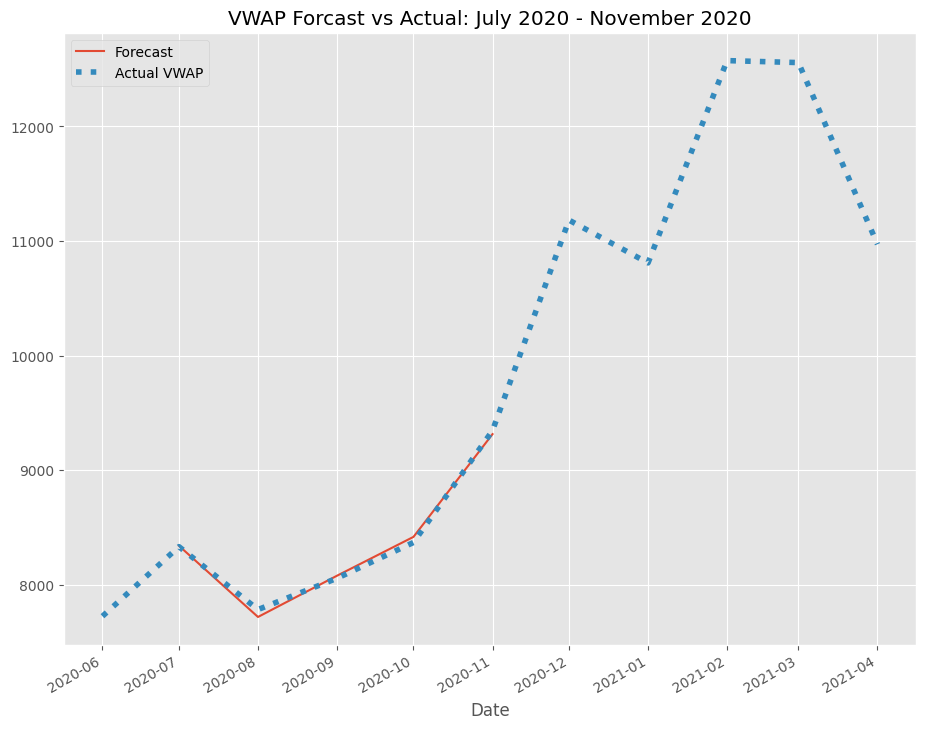

In [ ]:
fig = res.plot_predict('2020-07-01', '2020-11-01')
ax = df3['VWAP'].loc['2020-06-01':].plot(linewidth=4, linestyle=':', label='Actual VWAP')
plt.title('VWAP Forcast vs Actual: July 2020 - November 2020')
plt.legend()
plt.show()

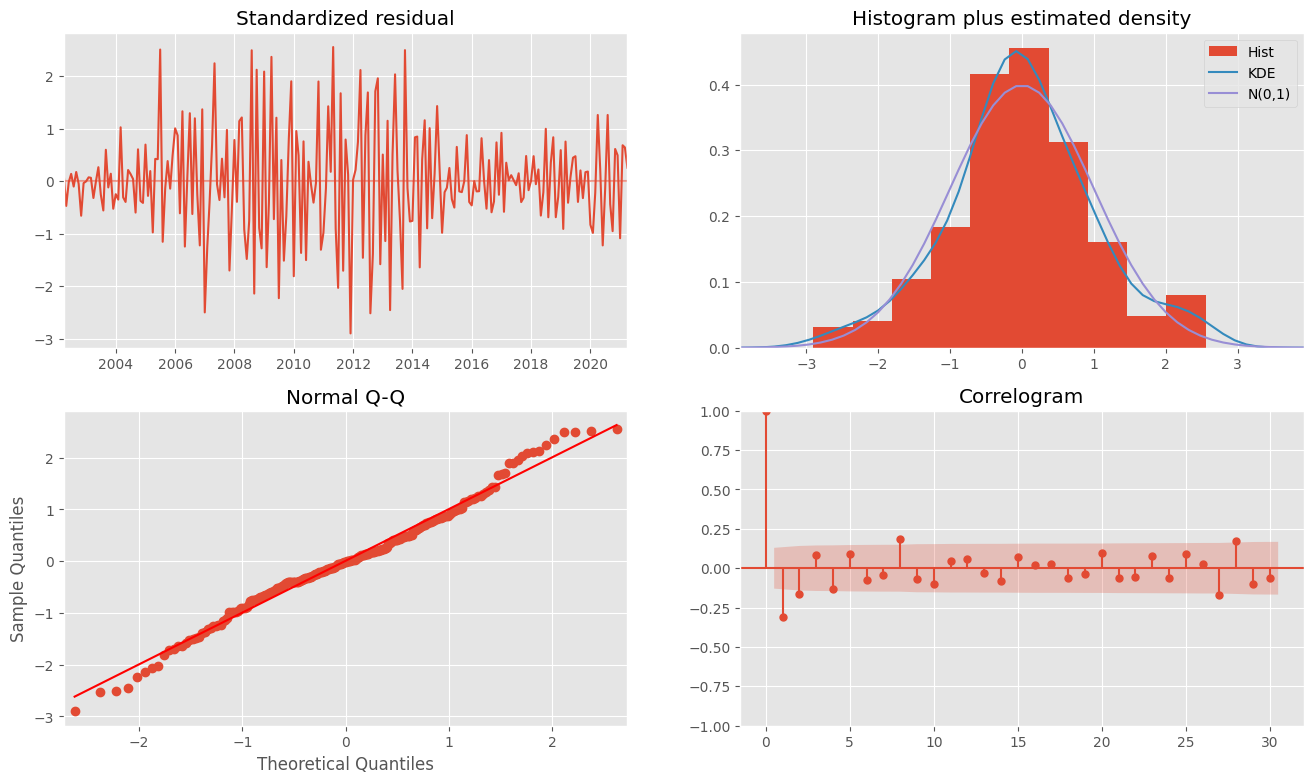

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [ ]:
rmse = math.sqrt(mean_squared_error(df3['VWAP'].loc['2014-01-01':'2020-11-01'],res.predict(start='2014-01-01',end='2020-11-01') ))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 31.848477448406065.


AutoRegressor has a good score! Now let's try ARIMA model. <br>
Ref:  https://www.kaggle.com/rohanrao/a-modern-time-series-tutorial

# ARIMA Models
An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average.

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast


Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3416.086, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3413.662, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3414.469, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3414.106, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3413.867, Time=1.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3405.322, Time=2.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3407.661, Time=1.95 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3407.830, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3414.716, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3403.338, Time=1.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3412.492, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3411.685, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3405.677, Time=1.98 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3405.844, Time=1.26 sec
 ARIMA(0,1,2)(0

<Axes: xlabel='Date'>

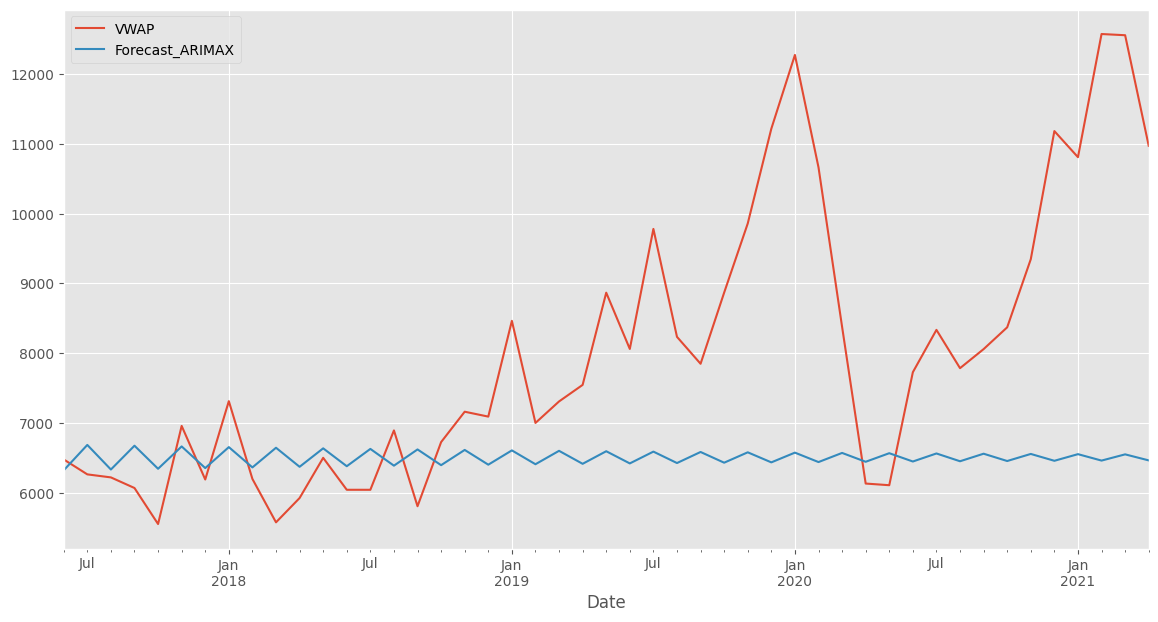

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 2450.0169073759207

MAE of Auto ARIMAX: 1756.159949328491


ARIMA models give a fair rmse and mae score. Let's see if deep learning models can do a better job in fitting to our dataset.

# Deep Learning Models
Let's explore some deep learning models on the dataset.
We'll try LTSM and RNN. RNN, a model designed for allowing information to persist in short term memory to predict subsequent values, should be best suited to our dataset, since we can see that autocorrelations don't show signs of seasonality, it tends to be manipulated by recent previous prices. We'll also apply LTSM, the special RNN model, which might reveal some interesting long term dependencies or relations in the dataset. Let's explore!


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
df4=df3.copy()

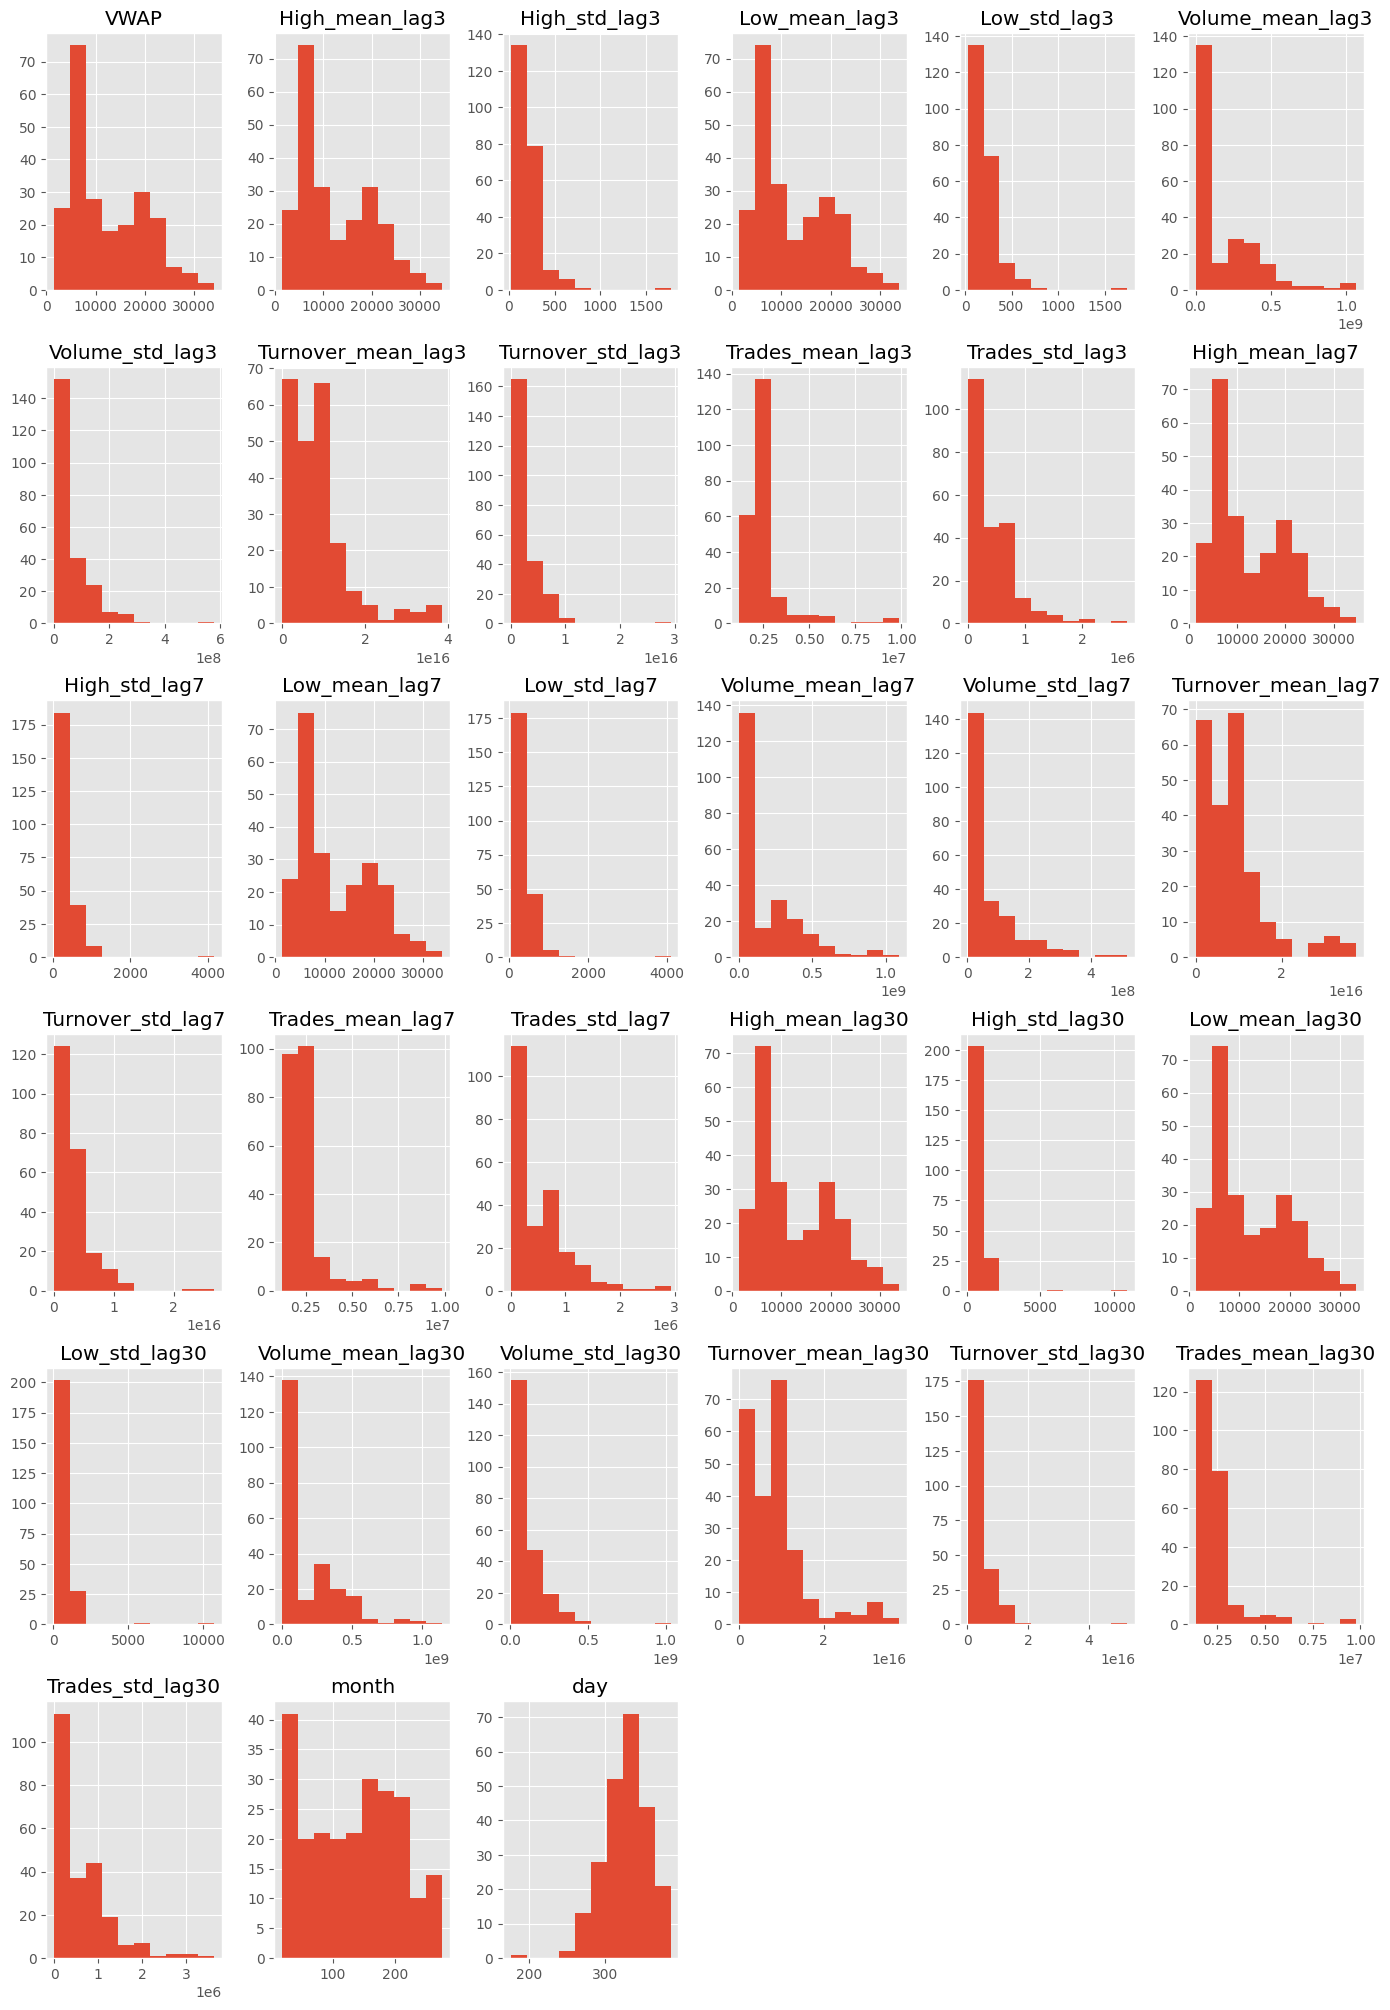

In [ ]:
fig = plt.figure(figsize = (17,25))
ax = fig.gca()
hist=df4.hist(ax = ax)

In [ ]:
dataset = df4.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [ ]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [ ]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100)            │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,905 (624.63 KB)

 Trainable params: 53,301 (208.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 106,604 (416.43 KB)

In [ ]:
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
rmse:0.0202516518699743 MAE:0.014814366586506367


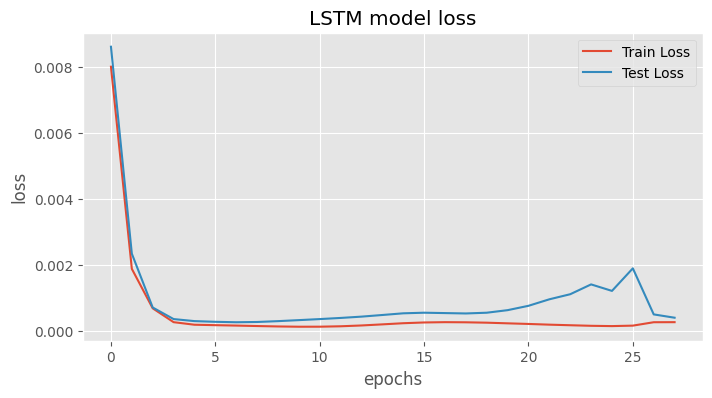

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

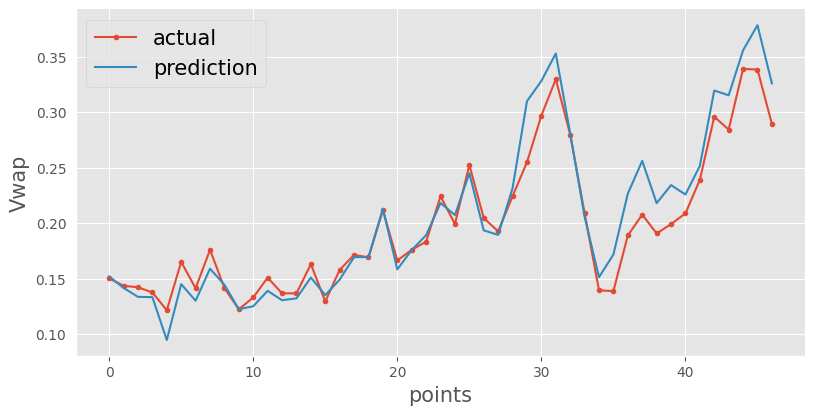

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

LSTM gives an excellent score on our dataset. Let's checkout a simple RNN model!

In [ ]:
model = Sequential()
model.add(SimpleRNN(units, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 100)            │        13,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,205 (157.05 KB)

 Trainable params: 13,401 (52.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,804 (104.71 KB)

In [ ]:
yhat2 = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat2)
print('rmse:{} MAE:{}'.format(rmse,mae))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
rmse:0.0202516518699743 MAE:0.029395991936326027


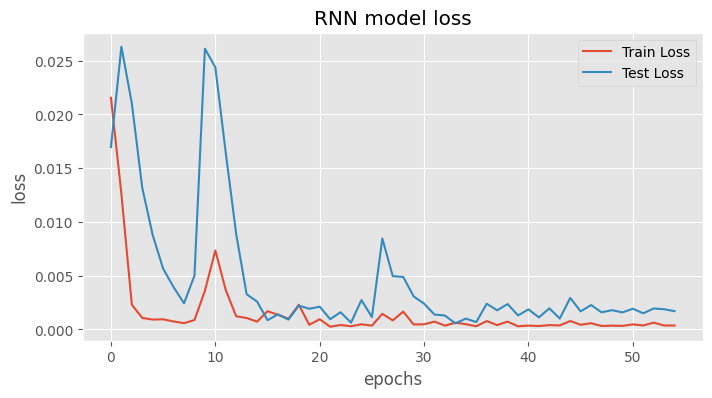

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

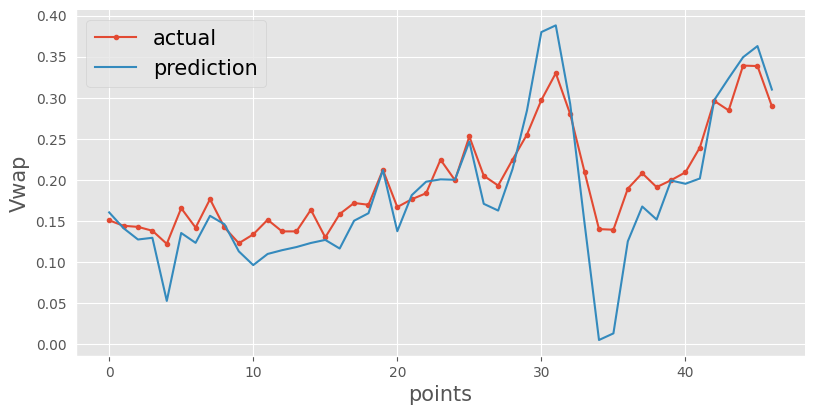

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="actual")
plt.plot(yhat2, label="prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Vwap', size=15)
plt.xlabel('points', size=15)
plt.legend(fontsize=15)
plt.show();

RNN performs rather poorly, in comparison to LTSM model, Though the RMSE score turned out to be the same approximately, MAE has increased by 3-4%, as we can see the results from the graphs above. We can say that, when we move from RNN to LSTM, we are introducing more & more controlling knobs, which control the flow and mixing of Inputs as per trained Weights. And thus, bringing in more flexibility in controlling the outputs. Thus, we obtain better results in LTSM.

In [ ]:
!pip install --upgrade pmdarima

In [ ]:
!pip install numpy==1.25.2 # Installing a specific, often compatible numpy version

In [ ]:
!pip install --upgrade pmdarima # Reinstalling pmdarima after numpy downgrade

In [ ]:
train_data_size = int(len(df3) * 0.8) # Define the training data size (80%)
df_train = df3[:train_data_size] # Split data into training set
df_valid = df3[train_data_size:] # Split data into validation set

print("Training data shape:", df_train.shape)
print("Validation data shape:", df_valid.shape)

Training data shape: (185, 33)
Validation data shape: (47, 33)
